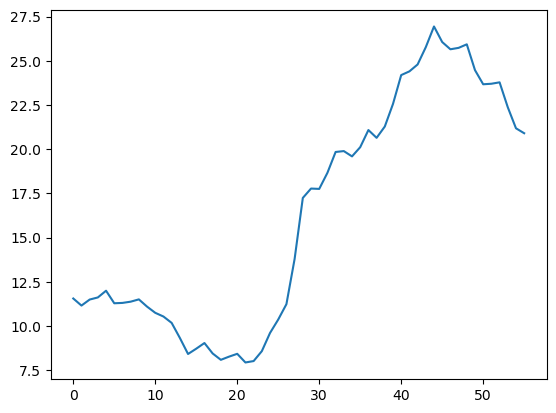

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_csv('Series2Session9.csv', sep=";",decimal=",")
y = datos.iloc[:,1]

plt.plot(y)
plt.show()


# by just looking at the plot we see that the data is not stationary in the mean, so we need some difference operator
# we dont know if we will need d (regulat operator) or D (seasonal operator)
# is it stationary in the variance? we cannot clearly say. We will be able to decide about the stationarity in the variance once we take the
# diff operator

In [2]:
# !pip install pmdarima

In [3]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 4
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

#because it is quarterly data, the season parameter is 4 (4 quarters within the calendar year)

# the adf tests tells us if we need a regular difference
# ndiffs tells us how many regular differences we need and the nsdiffs the number of seasonal diffs

# with p value 0.66 we say the data is not stationary in the mean 

# we need 2 regular differences

ADF test for the original series
Statistic Value: -1.2295875253565625
p-value: 0.6607401937990893
Regular differences:  2
Seasonal differences: 0


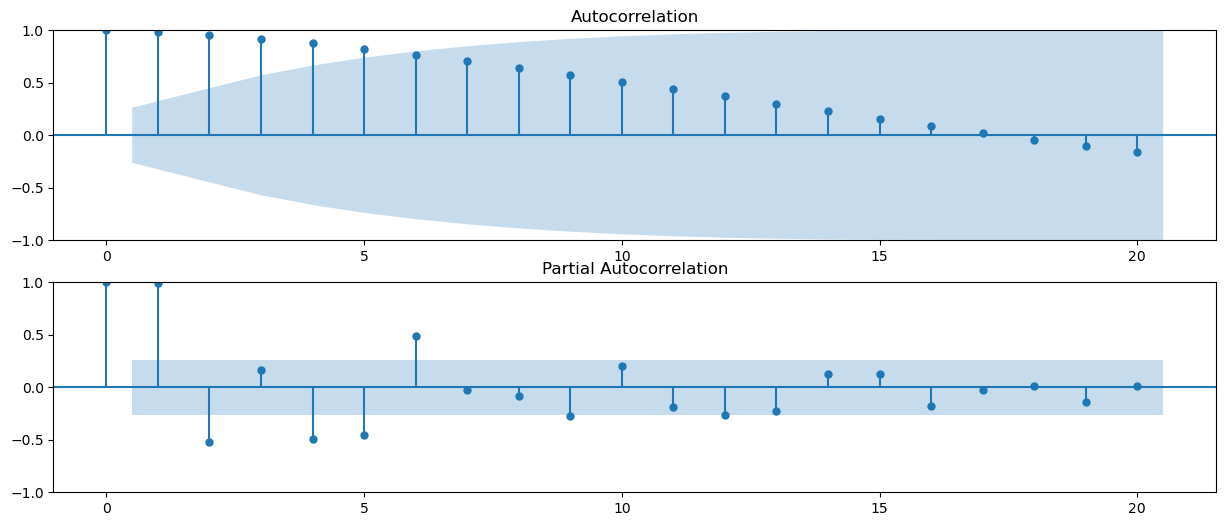

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 20 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()

# we use 20 lags ( 5 years of quarterly data). it is quite reasonable. DOnt use 20 years in the past because it does not make sense

                                     SARIMAX Results                                     
Dep. Variable:                             unemp   No. Observations:                   56
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 4)   Log Likelihood                 -50.265
Date:                           Thu, 23 Jan 2025   AIC                            104.530
Time:                                   20:18:48   BIC                            108.508
Sample:                                        0   HQIC                           106.065
                                            - 56                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4        0.7146      0.095      7.484      0.000       0.527       0.902
sigma2         0.3573      0.034     10.628

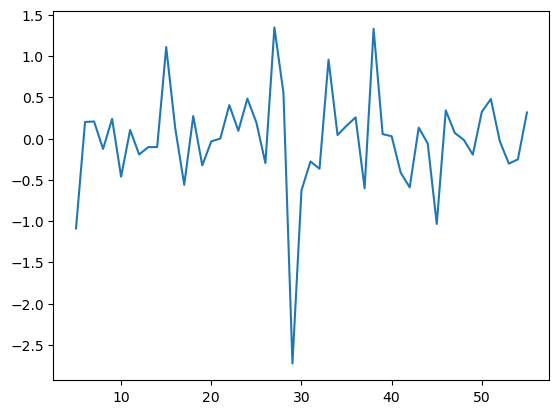

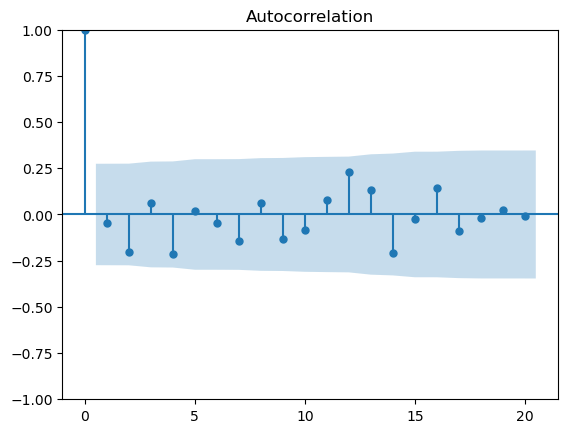

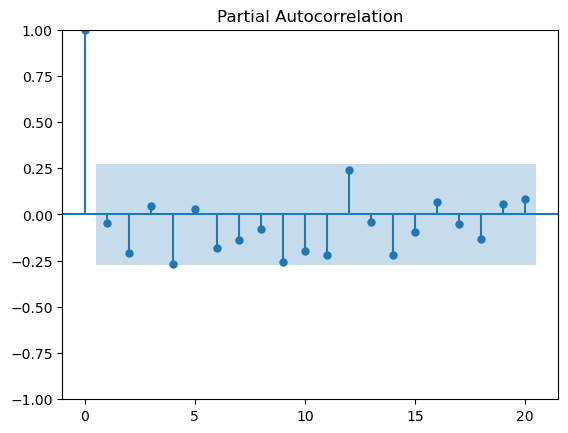

In [17]:
s = 4

fit = SARIMAX(endog = y, order = (0,2,0), seasonal_order = (1,0,0,s)).fit()
print(fit.summary())
residuos = fit.resid[s+1:]

nlags=20

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

# we apply a SARIMAX model with 2 regular differences and 0 seasonal differences
# we check if after taking the differences the data is stationary in the mean

# now the data looks stationary in the mean and in the variance (the data is not systematically increasing or decreasing in the mean)

# following the box jenking methodology, we already got that the data is no stationary. Now we have it stationary so now we need to answer the question
# if our data is already WN

# we take a look at the ACF ad PACF. The ACF looks more simple because we have less lags out of bounds
# in the PACF, we see the regular lags are 1 to 3 and the regular lags are 4, 8, 12, 16...
# we can start modeling the regular or the seasonal part
# we check from the PACF which lags are out of bound, and we would propose (3,2,0) and for the seasonal (3,0,0)
# we count until which bar the regular bars are out of bound and from the seasonal as well
# it is a seasonal AR (SAR) of order 3 because if we say it is of order 12 (3s), we are not modeling the seasonal, we are modeling the regular of 
# order 12
# when checking this model we see that none of our parameters are significant (in the columns P > z). So proabably we are undercomplicating it
# this is the reason why we should not execute the 2 models (regular and seasonal) at the same time at the beginning

# we start with the seasonal part. This would be a seasonal AR of order 3 (by looking at the PACF)
# again we have that none of our paramters are significant

# if we apply a seasonal AR with only 1 (1,0,0) which was clearly more our of bounds, we see that this is significant.
# so we are better in the way
# before saying that this is a valid model we need to check if our residuals are white noise
# we check that in the ACF and in the PACF we have nothing clearly out of bounds, so this is good
# we will run the box tests for our residuals


Ljung-Box for the residuals
      lb_stat  lb_pvalue
25  27.605844   0.326315
Shapiro test for residuals: Statistic value 0.8755057376630552 p-value 7.042418495845e-05


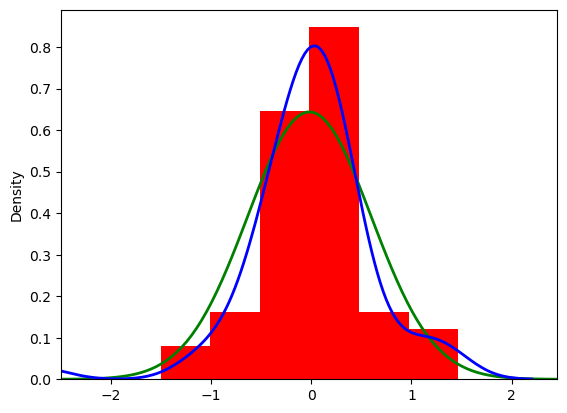

In [19]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

# my residuals are already uncorrelated (p value > 0.05), therefore there are already white noise
# so the residuals are telling me that this is already white noise and we can predict our model
# to predict the future the only thing we need to know is if they are white noise
# the rest of the things we are analyzing are extra information about our residuals

# looking at saphiro we see that the residuals are not gaussian white niose (not normal)
# therefore we cannot say anything about the strict white noise

Ljung-Box for squared residuals
      lb_stat  lb_pvalue
20  12.670863   0.891055


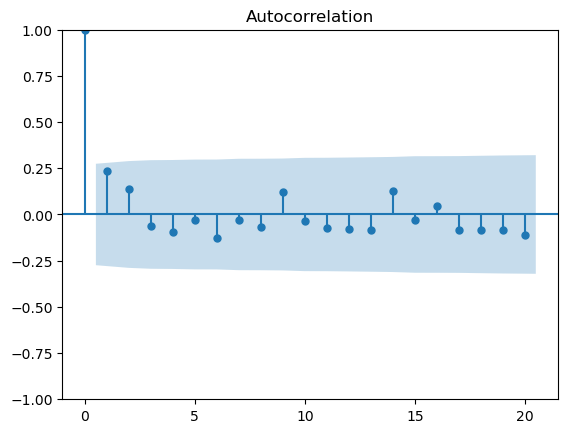

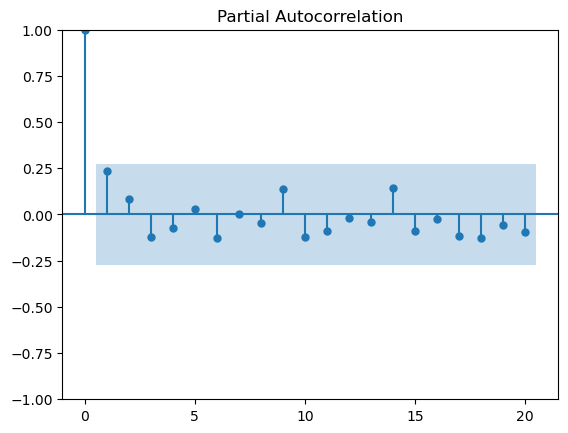

In [19]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[20])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

# we check this to see if it is stricts white noise
# we see that anything is out of bounds, it is uncorrelated
# p value > 0.05, we cannot say if they are independent but we can say that we dont need a model for the variance


# if the residuals are GWN, we know that they are SWN. And under normallity we can say that the residuals are independent
# if they are not normally distributed we cannot say if they are or not independent

# summary
# uncorrelated data + normallity = independent data (GWN --> SWN)
# if we dont have normallity we cannot say independence, but we can say if we need a model for the variance (if they are uncorrelated we dont need
# a model for the variance)
# if the squares of the residuals are correlated, we need a model for the variance


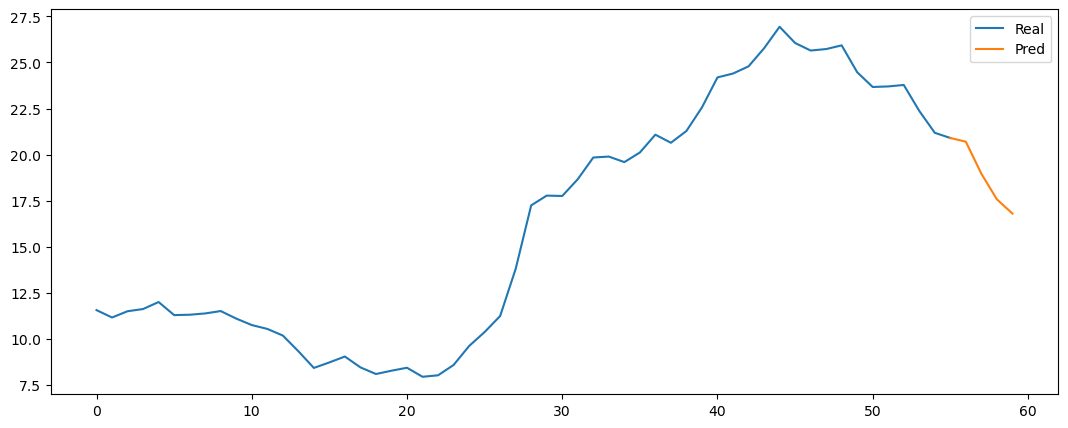

In [21]:
# Pintamos las siguientes 24 predicciones
y_pred = fit.forecast(steps = 4)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

# now what we should do would be to split the data into training and testing 
# we need to find models for the data and then for the different models we need to decide which one is the best one for predicting the feature
# we will need to find the mean absolute error, etc

In [23]:
# MORE FORECAST INFORMATION

forecast_result = fit.get_forecast(steps=4)

# in case we need a log transormation we would need to do reverse the transformation in the next line
# y_pred = np.exp(forecast_result.predicted_mean)
# in the case of the diff transformation, the SARIMA model it undoes it automatically

y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  
stderr = forecast_result.se_mean 

print("point predictions")
print(y_pred)
print("standard error of point predictions")
print(stderr)
print("confidence intervals around point predictions")
print(conf_int)


# the confindence intervals that we have is asumming normality
# they are asumming that the quantiles are +-1.96

point predictions
56    20.696607
57    18.957614
58    17.566912
59    16.795329
Name: predicted_mean, dtype: float64
standard error of point predictions
56    0.516408
57    1.080402
58    1.683696
59    2.353630
Name: var_pred_mean, dtype: float64
confidence intervals around point predictions
    lower unemp  upper unemp
56    19.684466    21.708747
57    16.840064    21.075163
58    14.266929    20.866895
59    12.182300    21.408359


In [25]:
# MORE FORECAST INFORMATION

media = np.mean(residuos)
desviacion_std = np.std(residuos)

# Standardized residuals
residuos_estand = (residuos - media) / desviacion_std

# Verification
#print("Standardized residuals:", residuos_estand)
print("Mean:", np.mean(residuos_estand))
print("Standard deviation:", np.std(residuos_estand))


quantile_2_5=np.quantile(residuos_estand, 0.025)
quantile_97_5=np.quantile(residuos_estand, 0.975)

print("We must compare the following numbers with +/- 1.96 from the standard normal")
print(quantile_2_5,quantile_97_5)

## we calculate our quantiles for our data that is not normal
# we see that the quantiles are not close to the normal ones, therefore instead of using in the confidence intervals +- 1.96 we should use the 
# qunatiles that we found

Mean: -6.530723674265627e-18
Standard deviation: 0.9999999999999999
We must compare the following numbers with +/- 1.96 from the standard normal
-1.797007059392168 2.1987315491359243
